**Convolutional Neural Networks (CNN)**

In [ ]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import keras_tuner
from sklearn.metrics import mean_squared_error, mean_absolute_error


"""# Data Loading and Preparation"""

data = pd.read_csv("data/nft_cleaned_data.csv")
data = data.dropna()
y_col = "trade_price"
data_y = data["trade_price"]
data.drop(["trade_price",'Unnamed: 0',"token_id",'Earring_value'],axis=1,inplace=True)

X_cols=data.columns
y_col = "trade_price"

X = data[X_cols]
y = data_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.expand_dims(X_train, axis=2)  # Reshape for CNN input

"""# Building Model"""

def build_model(hp):
  model = Sequential()
  # Input layer
  model.add(Input(shape=(X_train.shape[1],1)))

  # Conv1D layer
  model.add(Conv1D(
    filters=hp.Int("filters", min_value=32, max_value=256, step=32),
    kernel_size=hp.Int("kernel_size", min_value=2, max_value=5, step=1),
    activation='relu'
    ))

  # MaxPooling layer
  model.add(MaxPooling1D(pool_size=2))

  # Flatten layer
  model.add(Flatten())

  # Dense layers
  model.add(Dense(
    units=hp.Choice('units', values=[64, 128, 256, 512]),
    activation='relu'
    ))

  model.add(Dense(
      units=32,
      activation='relu'
      ))

  # Dropout layer
  if hp.Boolean("dropout"):
    model.add(Dropout(0.25))

  # Output layer
  model.add(Dense(1, activation='linear'))

  # Compile model
  optimizer = tf.keras.optimizers.Adam(
      hp.Choice('learning_rate', values=[1e-2, 1e-3])
       )

  model.compile(
      optimizer=optimizer,
      loss='mean_squared_error'
      )

  return model

In [ ]:

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=25,
    executions_per_trial=1,
    directory='./tuner',
    project_name='NFT_Pred'
)

"""#  Model Training"""

history = tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(best_hps.values)
best_model.summary()

"""# Model Predictions and Results Visualization"""

predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions.flatten())
mae = mean_absolute_error(y_test, predictions.flatten())
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Reloading Tuner from ./tuner/NFT_Pred/tuner0.json


Best hyperparameters:
{'filters': 64, 'kernel_size': 2, 'units': 128, 'dropout': False, 'learning_rate': 0.001}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense (Dense)               (None, 128)               90240     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (

In [ ]:
# Print the content of train_loss and val_loss to verify data
print("Train Loss Data:", train_loss)
print("Validation Loss Data:", val_loss)


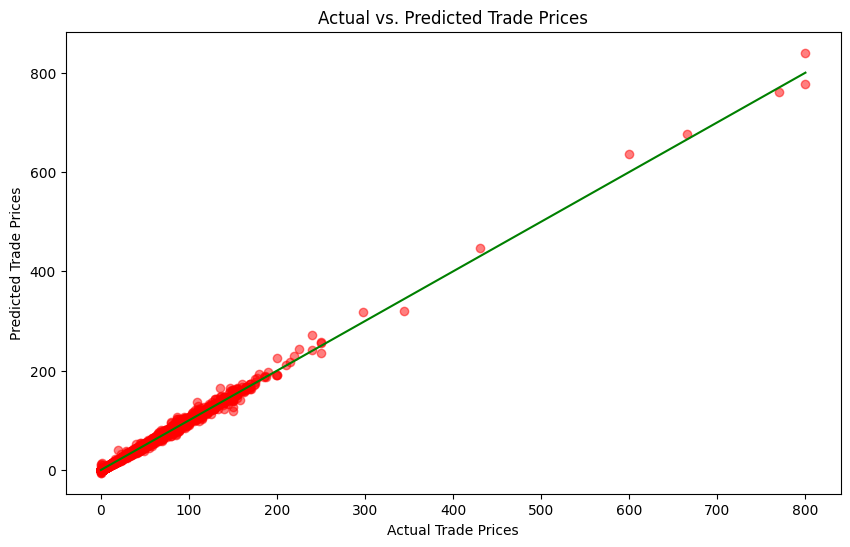

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions.flatten(), alpha=0.5, color='red')
plt.xlabel('Actual Trade Prices')
plt.ylabel('Predicted Trade Prices')
plt.title('Actual vs. Predicted Trade Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'green')
plt.show()

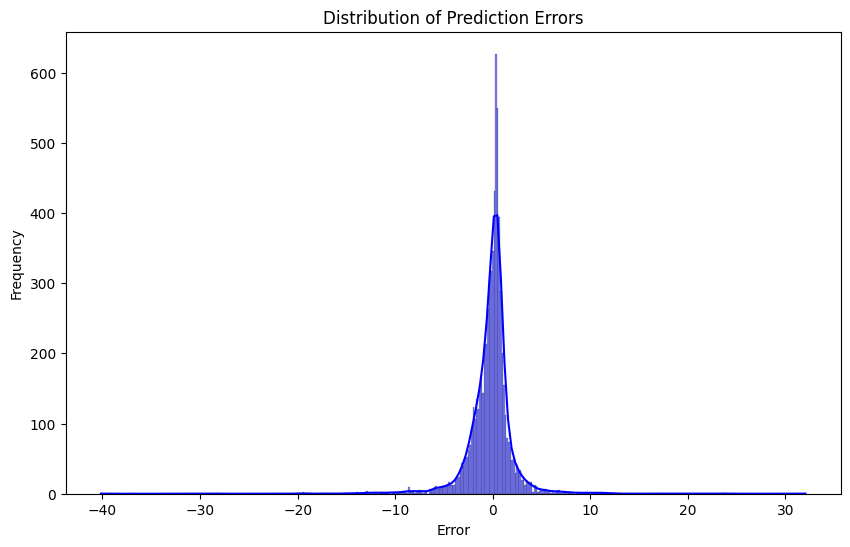

In [ ]:
import seaborn as sns
residuals = y_test - predictions.flatten()
# Error distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

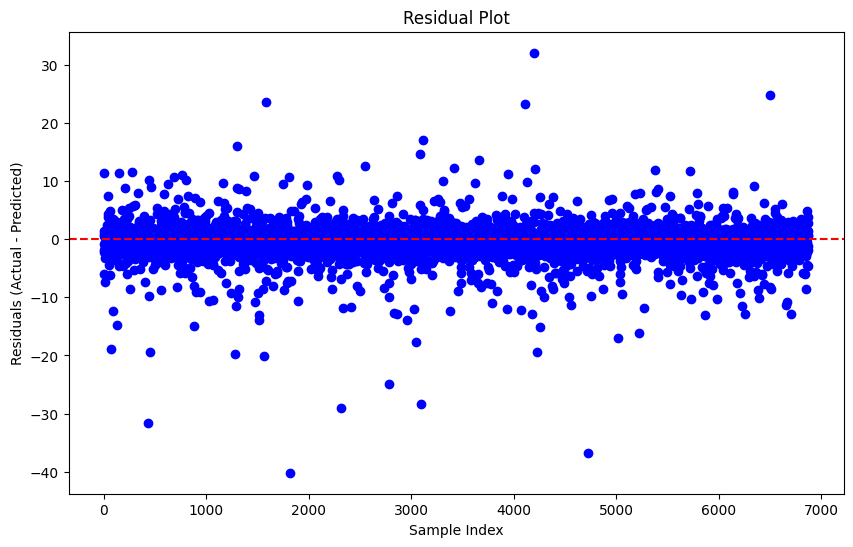

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - predictions.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, color='blue')
plt.title('Residual Plot')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()
